In [1]:
import pandas as pd
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
pd.options.display.max_rows = 999

In [2]:
# Function that loads data from api
def api_call(endpoint):
    call = requests.get(endpoint)
    response = call.json()
    
    return response

### Read and write pagecount desktop data

In [3]:
endpoint = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/en.wikipedia/desktop-site/monthly/2007120100/2016080100'

In [4]:
calls = api_call(endpoint)

In [ ]:
df = pd.DataFrame(calls['items'])

In [6]:
with open('pagecounts_desktop-site_200712-201608.json', 'w') as f:
    json.dump(calls, f)

### Read and write pagecount mobile data

In [7]:
endpoint = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/en.wikipedia/mobile-site/monthly/2007120100/2016080100'

In [8]:
calls = api_call(endpoint)

In [ ]:
df = pd.DataFrame(calls['items'])

In [10]:
with open('pagecounts_mobile-site_200712-201608.json', 'w') as f:
    json.dump(calls, f)

### Read and write pageview desktop data

In [11]:
endpoint = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia/desktop/user/monthly/2015070100/2019090100'

In [12]:
calls = api_call(endpoint)

In [ ]:
df = pd.DataFrame(calls['items'])

In [14]:
with open('pageviews_desktop_201507-201908.json', 'w') as f:
    json.dump(calls, f)

### Read and write pageview mobile-app data

In [15]:
endpoint = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia/mobile-app/user/monthly/2015070100/2019090100'

In [16]:
calls = api_call(endpoint)

In [ ]:
df = pd.DataFrame(calls['items'])

In [19]:
with open('pageviews_mobile-app_201507-201908.json', 'w') as f:
    json.dump(calls, f)

### Read and write pageview mobile-web data

In [20]:
endpoint = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia/mobile-web/user/monthly/2015070100/2019090100'

In [21]:
calls = api_call(endpoint)

In [ ]:
df = pd.DataFrame(calls['items'])

In [24]:
with open('pageviews_mobile-web_201507-201908.json', 'w') as f:
    json.dump(calls, f)

### Read in all data, save as dataframes, and ready for analysis

In [3]:
with open('pagecounts_desktop-site_200712-201608.json', 'r') as f:
    counts_desktop = json.load(f)

counts_desktop = pd.DataFrame(counts_desktop['items'])
counts_desktop.drop(columns=['access-site','granularity','project'], inplace=True)
counts_desktop.columns = ['counts_desktop','timestamp']

In [5]:
with open('pagecounts_mobile-site_200712-201608.json', 'r') as f:
    counts_mobile = json.load(f)

counts_mobile = pd.DataFrame(counts_mobile['items'])
counts_mobile.drop(columns=['access-site','granularity','project'], inplace=True)
counts_mobile.columns = ['counts_mobile','timestamp']

In [7]:
df = pd.merge(counts_desktop, counts_mobile, on='timestamp', how='outer')

In [9]:
with open('pageviews_desktop_201507-201908.json', 'r') as f:
    views_desktop = json.load(f)
views_desktop = pd.DataFrame(views_desktop['items'])
views_desktop.drop(columns=['access','agent','granularity','project'], inplace=True)
views_desktop.columns = ['timestamp','views_desktop']

In [11]:
with open('pageviews_mobile-app_201507-201908.json', 'r') as f:
    views_mobile_app = json.load(f)

views_mobile_app = pd.DataFrame(views_mobile_app['items'])
views_mobile_app.drop(columns=['access','agent','granularity','project'], inplace=True)
views_mobile_app.columns = ['timestamp','views_mobile_app']

In [13]:
with open('pageviews_mobile-web_201507-201908.json', 'r') as f:
    views_mobile_web = json.load(f)

views_mobile_web = pd.DataFrame(views_mobile_web['items'])
views_mobile_web.drop(columns=['access','agent','granularity','project'], inplace=True)
views_mobile_web.columns = ['timestamp','views_mobile_web']

### Merge data

In [16]:
df = pd.merge(df, views_desktop, on='timestamp', how='outer')
df = pd.merge(df, views_mobile_app, on='timestamp', how='outer')
df = pd.merge(df, views_mobile_web, on='timestamp', how='outer')

### Generate "pagecount_all_views" and "pageview_all_views", change data type of timestamp to datetime, fill NAs with 0

In [17]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y%m%d%H')
df.fillna(0, inplace=True)
df['views_mobile'] = df['views_mobile_app'] + df['views_mobile_web']
df.drop(columns=['views_mobile_app','views_mobile_web'], inplace=True)
df['pagecount_all_views'] = df['counts_desktop'] + df['counts_mobile']
df['pageview_all_views'] = df['views_desktop'] + df['views_mobile']
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month

In [19]:
df = df[['timestamp','year','month','counts_desktop','counts_mobile','pagecount_all_views',
   'views_desktop','views_mobile','pageview_all_views']]

df.columns = ['timestamp','year','month',
         'pagecount_desktop_views','pagecount_mobile_views','pagecount_all_views',
         'pageview_desktop_views','pageview_mobile_views','pageview_all_views']

df.drop(columns=['timestamp']).to_csv('en-wikipedia_traffic_200712-201809.csv', index=False)

### 

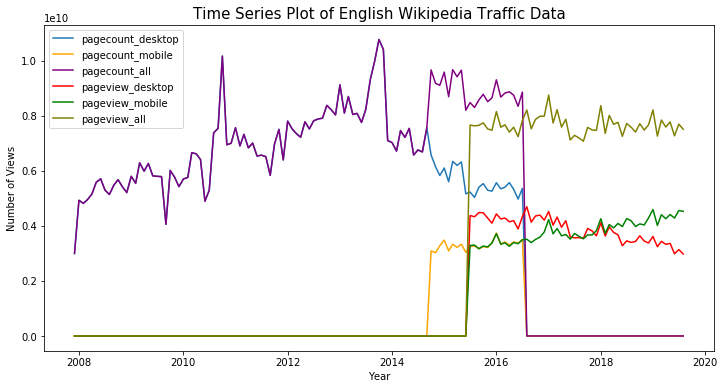

In [25]:
plt.figure(figsize=(12,6))
plt.plot(df['timestamp'], df['pagecount_desktop_views'], label='pagecount_desktop')
plt.plot(df['timestamp'], df['pagecount_mobile_views'], label='pagecount_mobile', color='orange')
plt.plot(df['timestamp'], df['pagecount_all_views'], label='pagecount_all', color='purple')
plt.plot(df['timestamp'], df['pageview_desktop_views'], label='pageview_desktop', color='red')
plt.plot(df['timestamp'], df['pageview_mobile_views'], label='pageview_mobile', color='green')
plt.plot(df['timestamp'], df['pageview_all_views'], label='pageview_all', color='olive')
plt.title('Time Series Plot of English Wikipedia Traffic Data', fontsize=15)
plt.xlabel('Year')
plt.ylabel('Number of Views')
plt.legend()
plt.savefig('en_wiki_traffic.jpeg');